# Stock Price Change Forecasting with Time Series: SARIMAX

Stock Price Change Forecasting with Time Series: SARIMAX
High-level understanding of Time Series, stationarity, seasonality, forecasting, and modeling with SARIMAX

Time series modeling is the statistical study of sequential data (may be finite or infinite) dependent on time. Though we say time. But, time here may be a logical identifier. There may not be any physical time information in a time series data. In this article, we will discuss how to model a stock price change forecasting problem with time series and some of the concepts at a high level.

Problem Statement
We will take Dow Jones Index Dataset from UCI Machine Learning Repository. It contains stock price information over two quarters. Let’s explore the dataset first:


We can see only a few attributes. But there are other ones also. One of them is “percent_change_next_weeks_price”. This is our target. We need to forecast it for subsequent weeks given that we have current week data. The values of the ‘Date’ attribute indicate the presence of time-series information. Before jumping into the solution, we will discuss some concepts of Time Series at a high level for our understanding.

Definition of Time series
There are different techniques for modeling a time series. One of them is the Autoregressive Process (AR). There, a time series problem can be expressed as a recursive regression problem where dependent variables are values of the target variable itself at different time instances. Let’s say if Yt is our target variable there are a series of values Y1, Y2,… at different time instances, then,


for all time instance t. Parameter µ is the mean of the process. We may interpret the term


as representing “memory” or “feedback” of the past into the present value of the process. Parameter ф determines the amount of feedback and ɛt is information present at time t that can be added as extra. Definitely here by “process”, we mean an infinite or finite sequence of values of a variable at different time instances. If we expand the above recurrence relation, then we get:


It is called the AR(1) process. h is known as the Lag.

A Lag is a logical/abstract time unit. It could be hour, day, week, year etc. It makes the definition more generic.

Instead of the only a single previous value, if we consider p previous values, then it becomes AR(p) process and the same can be expressed as:


So, there are many feedback factors like ф1, ф2,..фp for AR(p) process. It is a weighted average of all past values.

There is another type of modeling known as MA(q) process or Moving Average process which considers only new information ɛ and can be expressed similarly as a weighted average:


Stationarity & Differencing
From all of the equations above, we can see that if ф or θ< 1 then the value of Yt converges to µ i.e., a fixed value. It means that if we take the average Y value from any two-interval, then it will always be close to µ, i.e., closeness will be statistically significant. This type of series is known as Stationary time series. On the other hand, ф > 1 gives explosive behavior and the series becomes Non-stationary.

The basic assumption of time series modeling is stationary in nature. That’s why we have to bring down a non-stationary series to a stationary state by differencing. It is defined as:


Then, we can model ∆Yt again as time series. It helps to remove explosiveness as stated above. This differencing can be done several times as it is not guaranteed that just doing it one time will make the series stationary.

ARIMA(p,d,q) process
ARIMA is the join process modeling with AR(p), MA(q), and d times differencing. So, here Yt contains all the terms of AR(p) and MA(q). It says that, if an ARIMA(p,d,q) process is differentiated d times then it becomes stationary.

Seasonality & SARIMA
A time series can be affected by seasonal factors like a week, few months, quarters in a year, or a few years in a decade. Within those fixed time spans, different behaviors are observed in the target variable which differs from the rest. It needs to be modeled separately. In fact, seasonal components can be extracted out from the original series and modeled differently as said. It is defined as:


where m is the length of the season, i.e. degree of seasonality.

SARIMA is the process modeling where seasonality is mixed with ARIMA model.

SARIMA is defined by (p,d,q)(P, D, Q) where P, D, Q is the order of the seasonal components.

SARIMAX & ARIMAX
So far, we have discussed modeling the series with target variable Y only. We haven’t considered other attributes present in the dataset.

ARIMAX considers adding other feature variables also in the regression model.

Here X stands for exogenous. It is like a vanilla regression model where recursive target variables are there along with other features. With reference to our problem statement, we can design an ARIMAX model with target variable percent_change_next_weeks_price at different lags along with other features like volume, low, close, etc. But, other features are considered fixed over time and don’t have lag dependent values, unlike the target variable. The seasonal version of ARIMAX is known as SARIMAX.

## Data Analysis

We will start by analyzing the data. We will also learn some other concepts of time series along with the way.

Let’s first plot AutoCorelation Function(ACF) and PartialAutoCorelation Function (PACF) using statsmodel library:

In [177]:
import pandas as pd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data
from datetime import datetime
import json
import os
import random
import time
import requests
#from appetizer import Appetizer


import pandas as pd

df = pd.read_csv(r"\Users\admin\dow_jones_index.csv")
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,01/07/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,02/04/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


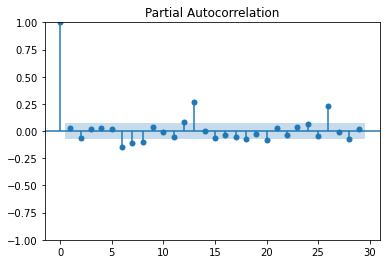

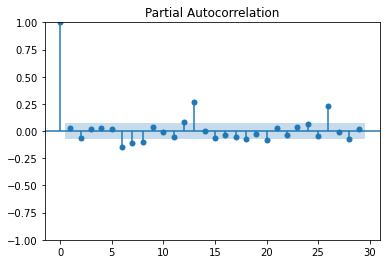

In [178]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_pacf(df['percent_change_next_weeks_price'])

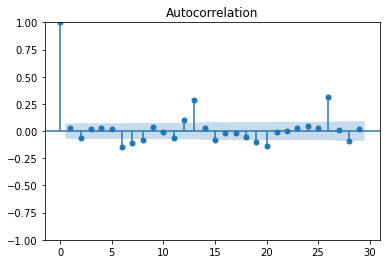

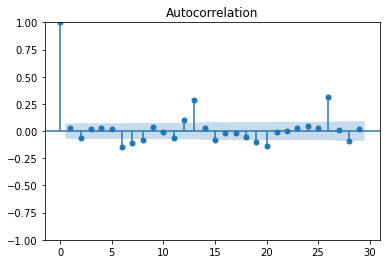

In [179]:
tsa_plots.plot_acf(df['percent_change_next_weeks_price'])

<AxesSubplot:>

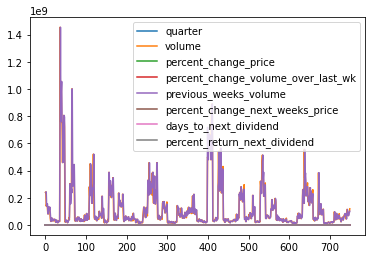

In [189]:
df.plot()

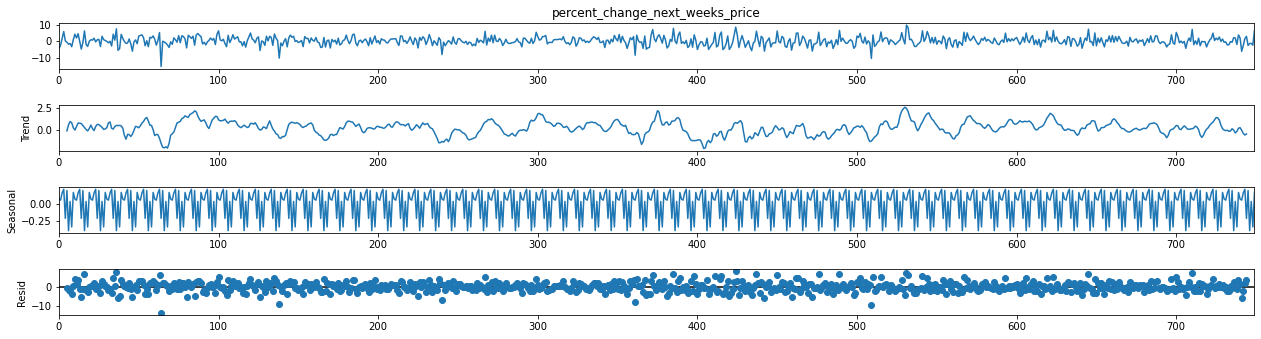

In [201]:
import statsmodels.tsa.seasonal as seasonal
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

fig = seasonal.seasonal_decompose(df['percent_change_next_weeks_price'], period=10, model='additive').plot()
fig.set_figheight(5)
fig.set_figwidth(20)
plt.show()

In [202]:
import statsmodels.tsa.stattools as tools

p_value = tools.adfuller(df['percent_change_next_weeks_price'], regression='nc')[1]
print('p-value: {}'.format(p_value))

p-value: 2.2044448943328737e-08


C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [203]:
import pandas as pd

df_transformed = pd.get_dummies(df, columns=['stock'])
df_transformed = df_transformed.drop(columns=['date'], axis=1)
df_transformed['open'] = df_transformed['open'].str.replace('$','')
df_transformed['high'] = df_transformed['high'].str.replace('$','')
df_transformed['low'] = df_transformed['low'].str.replace('$','')
df_transformed['close'] = df_transformed['close'].str.replace('$','')
df_transformed['next_weeks_open'] = df_transformed['next_weeks_open'].str.replace('$','')
df_transformed['next_weeks_close'] = df_transformed['next_weeks_close'].str.replace('$','')
df_transformed = df_transformed.fillna(0)
df_transformed.head()

C:\Users\Annette.Megrvarz\AppData\Local\Temp\ipykernel_26180\2888275625.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_transformed['open'] = df_transformed['open'].str.replace('$','')
C:\Users\Annette.Megrvarz\AppData\Local\Temp\ipykernel_26180\2888275625.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_transformed['high'] = df_transformed['high'].str.replace('$','')
C:\Users\Annette.Megrvarz\AppData\Local\Temp\ipykernel_26180\2888275625.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_transformed['low']

,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,...,stock_MRK,stock_MSFT,stock_PFE,stock_PG,stock_T,stock_TRV,stock_UTX,stock_VZ,stock_WMT,stock_XOM
0,1,15.82,16.72,15.78,16.42,239655616,3.79267,0.000000,0.0,16.71,...,0,0,0,0,0,0,0,0,0,0
1,1,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,...,0,0,0,0,0,0,0,0,0,0
2,1,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,15.87,...,0,0,0,0,0,0,0,0,0,0
3,1,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,16.18,...,0,0,0,0,0,0,0,0,0,0
4,1,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,17.33,...,0,0,0,0,0,0,0,0,0,0


In [204]:
X = df_transformed.drop(columns=['percent_change_next_weeks_price'], axis=1)
Y = df_transformed['percent_change_next_weeks_price']

In [205]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit()
for train_index, test_index in tss.split(X,Y):
  Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index] 
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]

In [206]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(Y_train.to_numpy(), exogenous=X_train.to_numpy(), m=2, seasonal=True, suppress_warnings = True,  step_wise=True, trace=True)           
auto_model.summary()

Performing stepwise search to minimize aic


C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=2336.633, Time=3.73 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2347.447, Time=1.74 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=2348.180, Time=3.30 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=2346.761, Time=3.24 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=5745.042, Time=2.11 sec


C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=2349.197, Time=3.44 sec


C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:38: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.arroots()))
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=2350.617, Time=3.82 sec


C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:38: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.arroots()))
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=2328.738, Time=5.22 sec


C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:38: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.arroots()))
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=2339.610, Time=4.50 sec


C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:38: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.arroots()))
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:40: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=2332.410, Time=4.36 sec


C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:40: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=2330.469, Time=5.11 sec
 ARIMA(0,0,1)(2,0,1)[2] intercept   : AIC=2326.644, Time=4.44 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=2334.689, Time=4.05 sec
 ARIMA(0,0,1)(2,0,0)[2] intercept   : AIC=2337.130, Time=3.32 sec
 ARIMA(0,0,1)(2,0,2)[2] intercept   : AIC=2330.165, Time=4.15 sec
 ARIMA(0,0,1)(1,0,0)[2] intercept   : AIC=2348.244, Time=2.72 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=2328.239, Time=3.72 sec
 ARIMA(0,0,0)(2,0,1)[2] intercept   : AIC=2325.188, Time=4.62 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=2332.092, Time=5.10 sec
 ARIMA(0,0,0)(2,0,0)[2] intercept   : AIC=2335.737, Time=3.24 sec
 ARIMA(0,0,0)(2,0,2)[2] intercept   : AIC=2328.919, Time=3.81 sec
 ARIMA(0,0,0)(1,0,0)[2] intercept   : AIC=2346.246, Time=2.57 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=2326.967, Time=2.83 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=2327.010, Time=3.27 sec
 ARIMA(0,0,0)(2,0,1)[2]             : AIC=2322.592, Time=3.72 sec
 ARIMA(0,0

C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:38: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.arroots()))
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  625
Model:             SARIMAX(2, 0, [1], 2)   Log Likelihood               -1114.296
Date:                   Tue, 05 Jul 2022   AIC                           2322.592
Time:                           15:24:53   BIC                           2531.167
Sample:                                0   HQIC                          2403.637
                                   - 625                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0071   1.17e-05    606.799      0.000       0.007       0.007
x2             0.0468      0.000    422.202      0.000       0.047       0.047
x3            -0.0405      0.000   -334.460      0.000      -0.041      -0.040
x4             0.0877      0.000    719.453      0.000       0.087       0.088
x5            -0.0369      0.000   -298.535      0.000      -0.037      -0.037
x6          4.072e-09    4.6e-10      8.859      0.000    3.17e-09    4.97e-09
x7             0.0342   4.17e-05    820.785      0.000       0.034       0.034
x8            -0.0003      0.002     -0.180      0.858      -0.004       0.003
x9          5.876e-10   4.42e-10      1.330      0.183   -2.78e-10    1.45e-09
x10           -1.3826      0.000  -1.12e+04      0.000      -1.383      -1.382
x11            1.4362      0.000    1.1e+04      0.000       1.436       1.436
x12           -0.0005      0.001     -0.622      0.534      -0.002       0.001
x13            9.6629      5e-06   1.93e+06      0.000       9.663       9.663
x14           -4.2167   1.91e-06  -2.21e+06      0.000      -4.217      -4.217
x15           -8.6707   7.73e-07  -1.12e+07      0.000      -8.671      -8.671
x16          -13.5307   8.89e-07  -1.52e+07      0.000     -13.531     -13.531
x17           -6.1906   1.88e-06  -3.29e+06      0.000      -6.191      -6.191
x18          -15.5434   2.44e-07  -6.36e+07      0.000     -15.543     -15.543
x19           -7.5605   1.83e-06  -4.14e+06      0.000      -7.561      -7.561
x20          -18.2423   7.47e-07  -2.44e+07      0.000     -18.242     -18.242
x21          -13.1353   5.63e-07  -2.33e+07      0.000     -13.135     -13.135
x22          -13.8186   2.55e-06  -5.41e+06      0.000     -13.819     -13.819
x23          -10.1932   1.33e-06  -7.67e+06      0.000     -10.193     -10.193
x24          -10.5797   3.19e-07  -3.31e+07      0.000     -10.580     -10.580
x25           -7.6587   3.38e-07  -2.26e+07      0.000      -7.659      -7.659
x26          -23.0867   1.93e-06   -1.2e+07      0.000     -23.087     -23.087
x27          -11.8628   3.57e-07  -3.33e+07      0.000     -11.863     -11.863
x28          -15.6832   5.58e-08  -2.81e+08      0.000     -15.683     -15.683
x29          -10.8733   1.67e-07  -6.52e+07      0.000     -10.873     -10.873
x30          -14.1890   3.95e-08  -3.59e+08      0.000     -14.189     -14.189
x31          -11.9501   4.37e-07  -2.73e+07      0.000     -11.950     -11.950
x32          -16.2639   1.09e-07  -1.49e+08      0.000     -16.264     -16.264
x33          -15.9260   6.34e-07  -2.51e+07      0.000     -15.926     -15.926
x34          -14.9729   6.77e-07  -2.21e+07      0.000     -14.973     -14.973
x35          -10.5306    4.9e-07  -2.15e+07      0.000     -10.531     -10.531
x36          -12.6652    1.6e-06  -7.91e+06      0.000     -12.665     -12.665
x37          -15.1200   1.19e-07  -1.27e+08      0.000     -15.120     -15.120
x38          -18.1722   1.61e-07  -1.13e+08      0.000

In [207]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(endog=Y_train.to_numpy(), exog=X_train.to_numpy().astype(float), order=(0, 0, 0),seasonal_order=(2, 0, 1, 2))
model = model.fit(disp=False)
model.summary()

C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  625
Model:             SARIMAX(2, 0, [1], 2)   Log Likelihood               -1114.296
Date:                   Tue, 05 Jul 2022   AIC                           2322.592
Time:                           15:25:53   BIC                           2531.167
Sample:                                0   HQIC                          2403.637
                                   - 625                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0071   1.17e-05    606.799      0.000       0.007       0.007
x2             0.0468      0.000    422.202      0.000       0.047       0.047
x3            -0.0405      0.000   -334.460      0.000      -0.041      -0.040
x4             0.0877      0.000    719.453      0.000       0.087       0.088
x5            -0.0369      0.000   -298.535      0.000      -0.037      -0.037
x6          4.072e-09    4.6e-10      8.859      0.000    3.17e-09    4.97e-09
x7             0.0342   4.17e-05    820.785      0.000       0.034       0.034
x8            -0.0003      0.002     -0.180      0.858      -0.004       0.003
x9          5.876e-10   4.42e-10      1.330      0.183   -2.78e-10    1.45e-09
x10           -1.3826      0.000  -1.12e+04      0.000      -1.383      -1.382
x11            1.4362      0.000    1.1e+04      0.000       1.436       1.436
x12           -0.0005      0.001     -0.622      0.534      -0.002       0.001
x13            9.6629      5e-06   1.93e+06      0.000       9.663       9.663
x14           -4.2167   1.91e-06  -2.21e+06      0.000      -4.217      -4.217
x15           -8.6707   7.73e-07  -1.12e+07      0.000      -8.671      -8.671
x16          -13.5307   8.89e-07  -1.52e+07      0.000     -13.531     -13.531
x17           -6.1906   1.88e-06  -3.29e+06      0.000      -6.191      -6.191
x18          -15.5434   2.44e-07  -6.36e+07      0.000     -15.543     -15.543
x19           -7.5605   1.83e-06  -4.14e+06      0.000      -7.561      -7.561
x20          -18.2423   7.47e-07  -2.44e+07      0.000     -18.242     -18.242
x21          -13.1353   5.63e-07  -2.33e+07      0.000     -13.135     -13.135
x22          -13.8186   2.55e-06  -5.41e+06      0.000     -13.819     -13.819
x23          -10.1932   1.33e-06  -7.67e+06      0.000     -10.193     -10.193
x24          -10.5797   3.19e-07  -3.31e+07      0.000     -10.580     -10.580
x25           -7.6587   3.38e-07  -2.26e+07      0.000      -7.659      -7.659
x26          -23.0867   1.93e-06   -1.2e+07      0.000     -23.087     -23.087
x27          -11.8628   3.57e-07  -3.33e+07      0.000     -11.863     -11.863
x28          -15.6832   5.58e-08  -2.81e+08      0.000     -15.683     -15.683
x29          -10.8733   1.67e-07  -6.52e+07      0.000     -10.873     -10.873
x30          -14.1890   3.95e-08  -3.59e+08      0.000     -14.189     -14.189
x31          -11.9501   4.37e-07  -2.73e+07      0.000     -11.950     -11.950
x32          -16.2639   1.09e-07  -1.49e+08      0.000     -16.264     -16.264
x33          -15.9260   6.34e-07  -2.51e+07      0.000     -15.926     -15.926
x34          -14.9729   6.77e-07  -2.21e+07      0.000     -14.973     -14.973
x35          -10.5306    4.9e-07  -2.15e+07      0.000     -10.531     -10.531
x36          -12.6652    1.6e-06  -7.91e+06      0.000     -12.665     -12.665
x37          -15.1200   1.19e-07  -1.27e+08      0.000     -15.120     -15.120
x38          -18.1722   1.61e-07  -1.13e+08      0.000

In [208]:
result = model.predict(start=1, end=125, exog=X_test.to_numpy().astype(float))

In [209]:
len(X_test), len(Y_test), len(result), len(X_train)

(125, 125, 125, 625)

In [210]:
from sklearn.metrics import mean_squared_error

mean_squared_error(result, Y_test)

9.367778697803809

<AxesSubplot:>

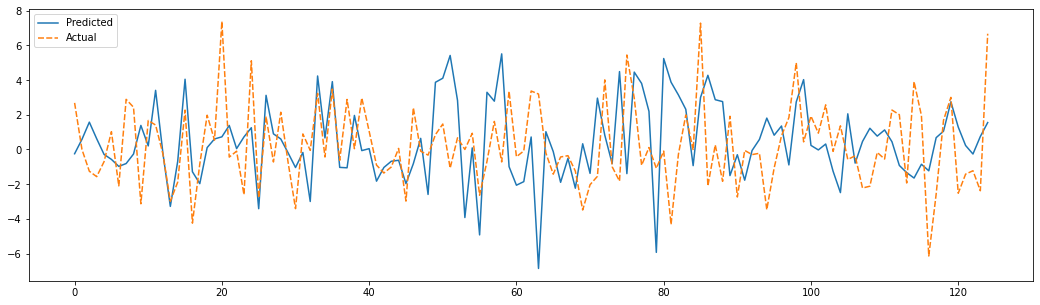

In [211]:
import seaborn as sns

plt.figure(figsize=(18,5))
sns.lineplot(data=pd.DataFrame({'Predicted':result,'Actual':Y_test.to_numpy()}))

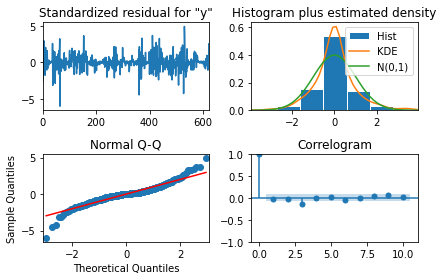

In [212]:
model.plot_diagnostics()
plt.tight_layout()
plt.show()